In [ ]:
!pip install kagglehub

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

c:\Users\USER\miniconda3\envs\imgcap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


In [2]:
# 데이터 확인
import os
print(os.listdir(path))
# captions.txt 파일 읽기
# import pandas as pd
captions_path = os.path.join(path, "captions.txt")
print(captions_path)

['captions.txt', 'Images']
C:\Users\USER\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\captions.txt


In [3]:
# Images 의 폴더의 파일 목록 확인
images_path = os.path.join(path, "Images")
print(os.listdir(images_path))

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19b

In [16]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 11.6/11.6 MB 72.7 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/3 [pytz]
   ---------------------------------------- 0/3 [pytz]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   ------------- -------------------------- 1/3 [tzdata]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ------------- 2/3 [pandas]
   -------------------------- ---------

In [4]:
# captions.txt 파일 내용을 pandas DataFrame으로 읽기
import pandas as pd
captions_df = pd.read_csv(captions_path)
# DataFrame의 첫 5개 행 출력    
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
!pip install torchvision

In [ ]:
!pip install matplotlib

In [5]:
# 토큰화(단어)
# 필요 라이브러리 설치
import pandas as pd
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import os
import re
from tqdm import tqdm

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
import unicodedata

In [8]:
# 전처리 함수 정의
    # 유니코드 문자열을 ASCII로 변환  NFD(Normal From Decompostion) 방식으로 분해
    # 비문자(숫자 특수기호) 제거
    # 불필요한 기호 제거
    # 양끝 공백 제거
def preprocess_text(text):
    context = ''
    # NFD(Normal From Decompostion) 방식으로 분해
    for ch in unicodedata.normalize('NFD', text):        
        if unicodedata.category(ch) != 'Mn':  # Mark, Nonspacing 'Mn'은 결합 문자(예: 악센트)로 분해된 문자
            # 'Mn'이 아닌 문자만 context에 추가
            context += ch

    context = context.lower()  # 소문자로 변환
    context = re.sub(r'[^a-z!?,]+', ' ', context)  # 비문자(숫자 특수기호) 제거
    return context.strip()  # 양끝 공백 제거


In [9]:
# caption 추출 : DataFrame에서 caption 열을 추출하고 전처리
captions = captions_df['caption'].apply(preprocess_text).tolist()
captions[100], captions_df['caption'][100]  #  전처리된 caption과 원본 caption 비교

('two different breeds of brown and white dogs play on the beach',
 'Two different breeds of brown and white dogs play on the beach .')

In [10]:
# 문장을 기반으로 어휘 사전을 구축하는 클래스 SOS EOS  중복되지 않도록 단어들을 추가
# 클래스명 Vocab
class Vocab:
    def __init__(self):
        self.word2idx = {'<SOS>': 0, '<EOS>': 1}  # 시작 토큰과 종료 토큰
        self.idx2word = {0: '<SOS>', 1: '<EOS>'}
        self.word2count = {}
        self.nwords = 2

    def build_vocab(self, captions):
        for word in captions.split():
            if word not in self.word2idx:
                self.word2idx[word] = self.nwords
                self.idx2word[self.nwords] = word
                self.word2count[word] = 1
                self.nwords += 1
            else:
                self.word2count[word] += 1      
# 단어 사전 생성
vocab = Vocab()
for caption in captions:
    vocab.build_vocab(caption)
# 단어 사전의 크기
print("Vocabulary size:", vocab.nwords)
# 단어 빈도수 상위 10개 출력
print("Top 10 words:", sorted(vocab.word2count.items(), key=lambda x: x[1], reverse=True)[:10])

Vocabulary size: 8446
Top 10 words: [('a', 62992), ('in', 18986), ('the', 18419), ('on', 10745), ('is', 9345), ('and', 8862), ('dog', 8138), ('with', 7765), ('man', 7274), ('of', 6723)]


In [11]:
# dataset 을 만들기위한 Custom Dataset 클래스 정의
# 이미지경로, 이미지파일명,캡션리스트,단어사전,맥스길이
# 클래스명 : CustomDataset
class CustomDataset(Dataset):
    def __init__(self, images_dir_path, img_filenames_list, captions, vocab, max_length=75):
        self.images_dir_path = images_dir_path
        self.img_filenames_list = img_filenames_list
        self.captions = captions
        self.vocab = vocab
        self.length = len(img_filenames_list)
        self.trasform = Compose([
            Resize((224, 224)),          
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.max_length = max_length
        
    def __len__(self):
        return self.length
    # 각 토큰을 고유한 숫자 식별자로 매핑하는 함수
    def _get_input_ids(self, sentence):
        input_ids = [0]*(self.max_length+2) 
        input_ids[0] = self.vocab.word2idx['<SOS>']  # <SOS> 토큰의 인덱스는 0
        input_ids[-1] = self.vocab.word2idx['<EOS>']
        for i, word in enumerate(sentence.split()):
            input_ids[i+1] = self.vocab.word2idx.get(word, 1)  # <EOS> 토큰의 인덱스는 1
        # torch 형태로 반환
        return torch.tensor(input_ids) #, dtype=torch.long)
    def __getitem__(self, index):
        imgfname,caption =  self.img_filenames_list[index], self.captions[index]
        imgfname = os.path.join(self.images_dir_path, imgfname)
        image = Image.open(imgfname)
        img = self.trasform(image)
        caption = self._get_input_ids(caption)
        return img, caption

In [ ]:
# vocab.idx2word

In [13]:
# 데이터 로더 생성
dataset = CustomDataset(images_path, captions_df['image'], captions, vocab)
# train dataset test dataset 분리
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [0.999, 0.001])  # 0.999 0.001
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# 데이터 수 확인
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 40415
Test dataset size: 40


In [14]:
# shape 확인
img, caption = next(iter(train_loader))
print("Image shape:", img.shape)
print("Caption shape:", caption.shape)

Image shape: torch.Size([64, 3, 224, 224])
Caption shape: torch.Size([64, 77])


In [15]:
# encoder 구성
class Encoder(nn.Module):
    def __init__(self, pretrained_feature_extractor):
        super(Encoder, self).__init__()
        self.pretrained_feature_extractor = pretrained_feature_extractor

    def forward(self, x):
        features = self.pretrained_feature_extractor(x)
        # 가중치중에서 fc 즉 분류기쪽만 가중치 업데이트를 하고 나머지 는 전부 freeze
        for name, param in self.pretrained_feature_extractor.named_parameters():
            if 'fc.weight' in name or 'fc.bias' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        return features

In [16]:
# 모델을 설계 및 학습(ResNet50 모델을 사용)
# ResNet50 의 마지막 레이어를 제거하고 특징 추출기로 사용하기위해 모델 구조 확인
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
# 구조 확인
# print(resnet)
# print([name for name,param in resnet.named_parameters()])
# 마지막 레이어를 변경
resnet.fc = nn.Linear(in_features=2048, out_features=1024)
encoder = Encoder(resnet).to(device)

In [17]:
# decode 구현  text 생성을 담당
# 인코더에서 추출된 이미지 특징을 바탕으로 순차적으로 생성해 나가는 시퀀스 생성 모델
# 임베딩 -> GRU->linear->Logsoftmax  예상되는 출력구조  단어분포(logsoftmax확률)
class Decoder(nn.Module):
    '''
    output_size  단어집합크기(vocab_size)
    embed_size 단어를 몇차원으로 임베딩할지 결정
    hidden_isze GRU의 hidden state
    '''
    def __init__(self, output_size, embed_size, hidden_size):
        super().__init__()
        # [batch, seq_len] -> [batch, seq_len,embed_size]
        self.e = nn.Embedding(num_embeddings=output_size,embedding_dim=embed_size)
        # 비선형 변환
        self.relu = nn.ReLU()
        # 순환계층
        # [ batch, seq_len, embed_size]
        self.gru = nn.GRU(embed_size,hidden_size,batch_first=True)
        # 출력계층
        self.ln = nn.Linear(hidden_size,output_size)
        self.lsoftmax = nn.LogSoftmax(dim=-1)
    def forward(self, x, prev_hidden):  # prev_hidden 이전 time step의 hidden stae(or inital state)
        x = self.e(x)  # 단어id -> 임베딩 벡터
        x = self.relu(x)
        output, hidden = self.gru(x,prev_hidden)
        y = self.ln(output)  # 단어분포를 벡터로 변환
        y = self.lsoftmax(y)
        return y,hidden


In [18]:
EMBEDED_SIZE = 300
HIDDEN_SIZE = 1024
decoder = Decoder(vocab.nwords, EMBEDED_SIZE,HIDDEN_SIZE).to(device)

In [19]:
vocab.nwords

8446

In [23]:
def train(epoch):
    encoder.train()
    decoder.train()
    losses = 0
    # 배치사이즈 만큼 데이터 가져옴
    for idx , (imgs,caption) in tqdm(enumerate(train_loader)):
        # 64,3,224,224 imgs
        # 64,77 caption
        imgs = imgs.to(device)
        caption = caption.to(device)
        extracted_features =  encoder(imgs)  #64 1024
        # extracted_features -> decoder_hidden  : [64,1024] -> [1,64,1024]
        decoder_hidden =  torch.reshape(extracted_features,(1,extracted_features.shape[0],-1 ))
        
        # caption[:, :-1]  다음문장 예측해야되서. 입력은 <sos> 단어,단어....
        # 다음 문장은 단어, 단어,,, <eos>
        # 캡션과 이미지 feature가 입력으로 들어감
        yhats, decoder_hidden =  decoder(caption[:, :-1],decoder_hidden)
        # 첫번째 단어를 제외
        gt = caption[:, 1:]
        # [batch, seq_len,vcab_size] -> (batch*seq_len, vocab_size)
        # 손실함수 NLLloss 입력형태로 변환 why? 최종 출력함수 logsoft 함수와 잘맞는 손실함수
        yhats_reshaped =  yhats.view(-1, yhats.shape[-1])
        gt = gt.reshape(-1)  # 평탄화  64, 72--> 94*72                
        loss = loss_fn(yhats_reshaped, gt)
        losses+=loss.item()
        
        opte.zero_grad()
        optd.zero_grad()

        loss.backward()
        opte.step()
        optd.step()
        if idx % 50 ==0:
            print(f'batch : {idx+1} loss = {losses / (idx+1)}')
    return losses / len(train_loader)

In [24]:
# 수치벡터를 문장으로 변환하는 함수
def ids2sentence(ids,vocab):
    sentence = ""
    for id in ids.squeeze():
        if id == 0:
            continue
        word = vocab.idx2word[id.item()]
        sentence += word + " "
        if id ==1 :
            break
    return sentence

In [ ]:
loss_fn = nn.NLLLoss(ignore_index=0).to(device)
optd = optim.Adam(decoder.parameters())
opte = optim.Adam(encoder.parameters())

n_epochs = 1
for i in range(n_epochs):
    print(f'epochs : {i+1} loss = {train(i+1)}')


In [ ]:
# 추론 inference
max_cap_length = 75
def eval_epoch():
    encoder.eval()
    decoder.eval()
    losses = 0
    with torch.no_grad():
        for i, (imgs, t_ids) in enumerate(test_loader):
            imgs = imgs.to(device) # 1 3 224 224
            t_ids = t_ids.to(device) # 1 77
            extracted_features = encoder(imgs)
            # 1 1 1024
            decoder_hidden =  torch.reshape(extracted_features,(1,extracted_features.shape[0],-1 ))
            input_ids = t_ids[:,0]  # sos 추출
            yhats = []
            pred_sentence = ''
            for j in range(1,max_cap_length+1):
                probs, decoder_hidden = decoder(input_ids.unsqueeze(0),decoder_hidden)
                yhats.append(probs)
                _,input_ids = torch.topk(probs,1,dim=-1)  # 확률이 가장 높은 단어 하나 선택
                input_ids = input_ids.squeeze(1).squeeze(1)                
                word = vocab.idx2word[input_ids.item()]
                pred_sentence += word + ' '
                if input_ids.item() == 1:
                    break
            gt_sentence = ids2sentence(t_ids,vocab)
            # 이미지 복원 transformer 가 정규화 한것을 복원  RGB
            img = imgs[0]
            img[0] = (img[0]*0.229)+0.485
            img[1] = (img[1]*0.224)+0.456
            img[2] = (img[2]*0.225)+0.406
            # c h w -> h w c  시각화를 위해서서
            plt.imshow(torch.permute(imgs[0],(1,2,0)).detach().cpu())
            plt.show()
            print(f'정답 문장 : {gt_sentence}')
            print(f'모델 생성 문장 : {pred_sentence}')

            yhats_cat = torch.cat(yhats, dim=1)
            yhats_reshaped = yhats_cat.view(-1, yhats_cat.shape[-1])
            gt = t_ids[:,1:j+1]  # 실제 정답 (sos제외)
            gt = gt.view(-1)
            loss = loss_fn(yhats_reshaped, gt)
            losses += loss.item()            
        print("-"*100)
        return losses / len(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0815775].


정답 문장 : two people are in a tent near a brick wall <EOS> 
모델 생성 문장 : a man is sitting on a large rock wall with a large white dog in the background of a large tent of a building with a large building in the background of a building with a large building in the background of a building with a red building in the background of the background of the background of the background of the background of the background of the background of the background of the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0735948].


정답 문장 : man on skis attempting to jump over a snow pile <EOS> 
모델 생성 문장 : a skier is jumping off a jump in the air on a snowy mountain range in the mountains in the mountains in the mountains in the mountains in the mountains in the mountains in the background setting the mountains of the mountains in the background background the mountains in the background background the mountains in the background background the mountains in the background background the mountains in the background background the mountains in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04705882..1.0815775].


정답 문장 : two blonde girls wear sports jerseys while watching a game together <EOS> 
모델 생성 문장 : a group of people are watching a man in a red and white shirt and a red shirt is holding a red flag in the background of a crowd of people in the background , one hand to the other people in the background watch the other people are watching the other people watch the other people are watching the other people watch the other people watch the other people are watching the other people 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0855688].


정답 문장 : two boys pose with an action hero <EOS> 
모델 생성 문장 : two boys are posing for a picture with a red and white toy in the background , one is holding a red toy in the background and the other team are nearby the street in the background with a red and white dog in the background , one is holding a red toy in the background , one is holding a red toy in the background of the background of the background in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0376734].


정답 문장 : a person in a dark wetsuit is surfing <EOS> 
모델 생성 문장 : a man in a black and white suit is in the water with a man in the background is holding a stick in his hand in the background of the ocean in the background is holding a stick in his hand in the background of the ocean in the background is holding a stick in his hand in the background of the ocean in the background background the ocean in the background background the ocean 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.0855688].


정답 문장 : a few players show off their jousting skills in a gym <EOS> 
모델 생성 문장 : two men in white suits are performing a jump in a white and white jersey and a man in a white uniform is holding a sword and a man in a white uniform is holding a sword and a white ball in the background of the opposing team is holding a ball in the background while the other team watches the other team watch the ball in the background watch the ball in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0855688].


정답 문장 : a man piloting a boat with goods in the back <EOS> 
모델 생성 문장 : a woman is sitting in a large pool with a large stick in the background of a lake in the background with a man in the background is holding a baby in the background of a lake in the background of a lake in the background of a lake in the background of a lake in the background of a lake in the background of a lake in the background of a lake in the 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607842..1.08956].


정답 문장 : a man in a red sweatshirt and a hat is looking at his phone while another man in black walks closer to him down the sidewalk <EOS> 
모델 생성 문장 : a man in a red hat and a woman in a red hat and a woman in a red hat and a red hat is standing in a street with a red and white dog in the background , one is holding a red bag in the background of a city street , one is holding a red bag in the background of a city street , one is holding a red bag in the 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : a man takes photos on the water s edge <EOS> 
모델 생성 문장 : a man and a woman are standing on a dock near a lake and a man in a white shirt and a black dog is standing in front of a lake and a man in a blue shirt and a white shirt is standing in the water with a man in the background and a lake in the background of a lake in the background setting a picture of the water and a man in 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.08956].


정답 문장 : a group of people with brooms standing in the snow with a dog in the forefront <EOS> 
모델 생성 문장 : a group of people are in the snow in a snow covered area in the snow with a red and white dog in the background in the snow in the snow covered ground in the snow covered area in the snow covered ground in the background area in the snow covered ground in the background area in the background of the snow covered ground in the background area in the background of the snow covered 
정답 문장 : a child in green shoes staring down a drain <EOS> 
모델 생성 문장 : a little boy in a green shirt is playing in a pool with a tennis ball in his mouth and a white shirt and a white shirt and a white shirt in a green shirt and a white shirt and a white shirt is running in a house in front of a house in front of a building building with a tennis ball in the background of a building in the background setting a tennis 
정답 문장 : a brown dog and a black dog are playing with a red frisbee <EOS> 
모델 생성 문장 : a dog 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.0217083].


정답 문장 : two dogs playing in the ocean <EOS> 
모델 생성 문장 : a dog is jumping in the water with a stick in his mouth in the background with a stick in his mouth in the background with a stick in his mouth in the background , the background is in the background , the background is in the background , the background is in the background , the background is in the background , the background is in the background , the background is in the 
정답 문장 : eight men and women are posed with arms outstretched in a step fashion <EOS> 
모델 생성 문장 : a man in a white shirt and a woman in a white shirt and a black shirt is sitting on a large rock wall with a man in the background , and a woman in a white shirt and a white shirt and a black shirt is standing behind a large statue of a building and a man in a white shirt and a white shirt and a black shirt is in the background with 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764705..1.0855688].


정답 문장 : a child hits a baseball into a net <EOS> 
모델 생성 문장 : a boy in a white uniform is jumping up to catch a ball in a field with a ball in his mouth and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt in a white uniform , one is trying to block a ball in the air while another watches watches him watches him in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607842..1.08956].


정답 문장 : the white dog is on its back in the sand with paws in the air <EOS> 
모델 생성 문장 : a dog runs through the sand with a stick in its mouth in the background with a stick in its mouth in the background with a stick in its mouth in the background behind it is in the background with a stick in its mouth in the background behind it is in the background with a stick in its mouth in the background behind it is in the background with a stick in its mouth 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : a woman in a red sweater walks by two younger women talking near a busy street <EOS> 
모델 생성 문장 : a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red jacket and a woman in a red 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035294116..1.0855688].


정답 문장 : three dogs play in a grassy field <EOS> 
모델 생성 문장 : a dog runs through a grassy area with a dog in the background in the background with a stick in his mouth in the background of a grassy area in the background area in the background of a grassy area in the background area in the background of a grassy area in the background area in the background of the woods and a dog in the background area in the background of the woods and 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0696037].


정답 문장 : a bicyclist is performing a trick on a tall tree <EOS> 
모델 생성 문장 : a man on a bike is performing a jump on a bicycle in a city street with a bicycle in the background behind him in the background background the ground in the background behind him in the background background the ground in the background background the background of the background of the background of the background of the background of the background of the background of the background of the background of the background of 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.078958005..1.0616211].


정답 문장 : two dogs play out in the snow covered grass <EOS> 
모델 생성 문장 : a golden dog is running in the snow with a stick in its mouth in the background with a stick in its mouth in the background with a stick in its mouth in the background in the background of the ocean in the background setting the camera in the background of the ocean in the background setting the camera in the background of the ocean in the background setting the camera in the background of 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0815775].


정답 문장 : three dogs walk near the fountain <EOS> 
모델 생성 문장 : a dog is jumping in a pool with a dog in the background of a building with a dog in the background of a building with a dog in the background of a building with a dog in the background of a building with a dog in the background of a building with a dog in the background of a building with a dog in the background of a building in the background setting a 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0855688].


정답 문장 : a little girl and boy play frisbee together in a grassy area <EOS> 
모델 생성 문장 : two boys are standing in a grassy area with a building in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.08956].


정답 문장 : a man dressed for cold weather plays with a stick with his black and brown dog <EOS> 
모델 생성 문장 : a man in a black jacket is jumping up a dog to a man in a red jacket is walking through a grassy area with a dog in the background with a dog in the background behind him in the background , chased by the dog is nearby the ground in the background , while another dog watches him in the background behind him in the background , the background is nearby the ground in 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : four people laughing and sitting on a couch <EOS> 
모델 생성 문장 : a group of people sit on a bed and one is holding a sword and a man in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.08956].


정답 문장 : jumping girl grabs her feet , plants in background <EOS> 
모델 생성 문장 : a girl in a white shirt and pink pants is jumping in the air in front of a large tree in the air in front of a large tree in the background , one is in the background , one is in the background , one is in the background , one is in the background , one is in the background , one is in the background , one is in the background , 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.031372547..1.0496471].


정답 문장 : a girl leaps into the air while standing by the ocean <EOS> 
모델 생성 문장 : a man is jumping in the sand at the beach with a man in the background is holding a rope in the background and the ocean in the background is holding a stick in the background and the ocean in the background is holding the ball in the background and the ocean in the background is nearby the ocean in the background and the ocean in the background is holding the ball in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0097344].


정답 문장 : man standing on one arm with feet in the air on playground equipment with a body of water in the background <EOS> 
모델 생성 문장 : a man in a white shirt is jumping off a railing in a large pool with a large white and blue sky in the background background the background of the background of a building in the background setting a picture of the background of the background of the background of the background of the background of the background of the background of the background of the background of the background of the background of the 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039215684..1.0855688].


정답 문장 : little leaguer getting ready for pitch <EOS> 
모델 생성 문장 : a baseball player in a white uniform is holding a baseball bat in the air while a man in a white uniform is holding a baseball bat in the background , holding a ball in his hand and the other team is holding a ball in his hand on the ground in the background , the background is holding a ball in his hand and the other team is nearby the base of the distance 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0815775].


정답 문장 : a cyclist rides his black bicycle while wearing a yellow jacket and white helmet <EOS> 
모델 생성 문장 : a man in a red helmet is riding a bicycle in a city street with a bicycle in the background of a city street with a bicycle in the background behind him in the background area behind him in the background area behind him in the background area behind him in the background background the background of the road in the background behind him in the background background the background of the road in the 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : two girls playing catch on a lawn <EOS> 
모델 생성 문장 : a dog jumps to catch a frisbee in a grassy yard with a ball in its mouth in the background of a building in the background setting a tennis ball in the background of a grassy area in the background setting a tennis ball in the background of the grass in the background setting the ball in the background of the grass in the background setting the ball in the background of the grass in 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.041143].


정답 문장 : a biker enjoys a coffee <EOS> 
모델 생성 문장 : a man in a leather jacket is riding a bicycle in a city street with a bicycle in the background of a city street with a bicycle in the background , and a man in a red jacket and a helmet in a city street , one is riding a bicycle in the street with a man in the background is riding a bicycle in the street with a man in the background is holding 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0656123].


정답 문장 : two dogs face each other in a field <EOS> 
모델 생성 문장 : a dog runs through a field with a tennis ball in its mouth in the grass in front of a grassy area in the grass setting a tennis ball in its mouth in the background , one is running in the grass by a grassy area in the background setting a tennis ball in its mouth in the background setting a tennis ball in its mouth in the background setting a tennis ball in its 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0656123].


정답 문장 : two children with a yellow and blue umbrella play in the bathtub <EOS> 
모델 생성 문장 : a man in a white shirt and a white shirt is holding a large stick in his mouth and a man in a white shirt and a white shirt is in the air in front of a large statue of water and a man in a red shirt and a white shirt is in the background with a large stick in the background of the ocean in the background of the ocean , holding a 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0855688].


정답 문장 : two women sitting on a bench , their faces obscured , with one woman carrying an inflatable tiger and the other woman in a disney snow white costume <EOS> 
모델 생성 문장 : a man in a white shirt and a woman in a white shirt and a woman in a white shirt and a black shirt is holding a sword and a woman in a white shirt and a black shirt and a white shirt and a black shirt is holding a sword and a man in a red shirt and a black shirt is holding a sword and a woman in a red shirt and a 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : a young girl slides down a green plastic slide on a playground <EOS> 
모델 생성 문장 : a little girl in a blue shirt is sliding down a blue slide slide in a pool while a boy in a blue shirt and blue shorts is sitting in a pool while a boy in a blue shirt and blue shorts is sitting in a pool and blue slide in a pool area in a pool and blue slide in the background of a pool and blue slide in the background area of a 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.08956].


정답 문장 : a girl hangs upside down on a swing set at a park <EOS> 
모델 생성 문장 : a girl in a pink shirt is jumping off a swing in a grassy area with a rope in the background , while others watch her arms around her face in the background , one is wearing a red shirt and a pink shirt and a pink shirt is in the background , one is holding a rope in the background , one hand to the ground in the background background the background is nearby 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686303..1.0616211].


정답 문장 : a little girl in an orange dress is running through the sprinkler in the yard <EOS> 
모델 생성 문장 : a little boy in a red shirt is running through a field of grass and a red ball in the background with a red ball in his mouth in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background area in the background 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.0616211].


정답 문장 : two girls giving a large dog a bath <EOS> 
모델 생성 문장 : two blonde women are sitting in a large pool with a dog in the background , one is holding a toy in its mouth , while a woman in a white dress is holding a toy in the background of a woman s lap of a woman in a white dress is holding a toy in the background of a woman s face is holding a toy in the background of the ocean s lap 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.082352936..1.0137256].


정답 문장 : a girl running with outstretched arms <EOS> 
모델 생성 문장 : a little girl in a pink dress is jumping in the air on a trampoline in front of a house in the background with a tennis ball in the background behind her face in the background , the background is nearby the ground in the background , the background is nearby the ground in the background , the background is nearby the ground in the background , the background is nearby the ground in the 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


정답 문장 : a rider on motorcycle , riding over rocks <EOS> 
모델 생성 문장 : a man in a red helmet is riding a red bicycle in the air on a dirt path in the woods with a mountain in the background behind him in the background of the mountains in the background behind him in the background behind him in the background background the mountains in the background behind him in the background background the mountains in the background background the mountains in the background background the mountains in 
----------------------------------------------------------------------------------------------------
epochs : 1 loss = 6.560984182357788


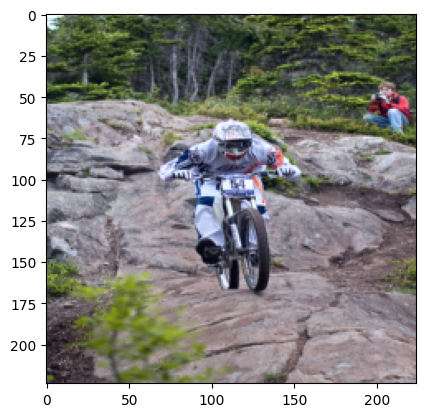

In [40]:
loss_fn = nn.NLLLoss(ignore_index=0).to(device)
optd = optim.Adam(decoder.parameters())
opte = optim.Adam(encoder.parameters())

n_epochs = 1
for i in range(n_epochs):
    print(f'epochs : {i+1} loss = {eval_epoch()}')